/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

--- Ensemble Evaluation Metrics (MLP + LSTM + CNN-BiGRU) ---
Accuracy: 0.9925
F1 Score: 0.8872
Precision: 0.9365
Recall: 0.8429
Specificity: 0.9979
AUC: 0.9758
Log Loss: 0.0351
MCC: 0.8847
Kappa: 0.8834
Misclassification Error: 0.0075


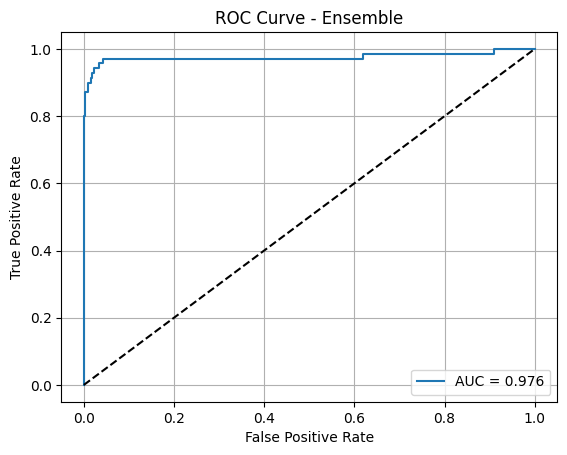

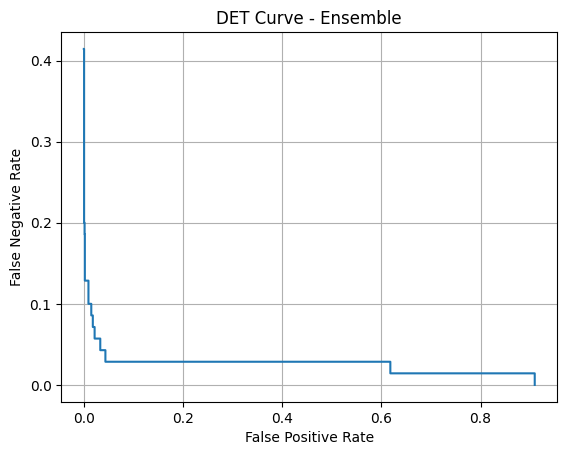

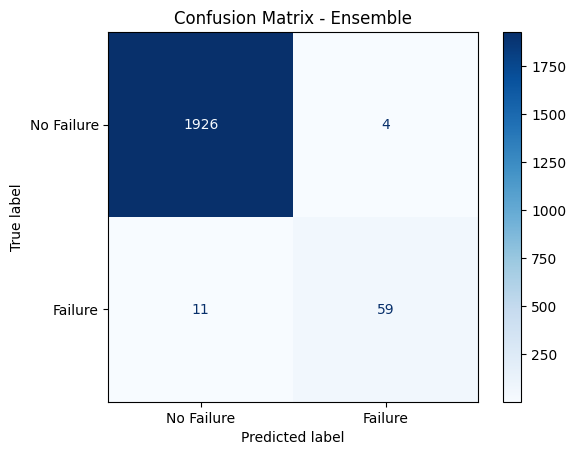

In [1]:
# Ensemble Learning using MLP, LSTM, and CNN+BiGRU

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, log_loss, matthews_corrcoef, cohen_kappa_score,
    roc_curve, det_curve, ConfusionMatrixDisplay
)

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model as KerasModel

# STEP 1: Load and Prepare Data
df = pd.read_csv("file1.csv")
df["Failure"] = (df["Diagnostic"] != "No failure").astype(int)
df.drop(columns=["UDI", "Date", "Product ID", "Diagnostic"], inplace=True)

X = df.drop(columns=["Failure"])
y = df["Failure"]

# STEP 2: Preprocessing
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, stratify=y, random_state=42)

X_train_seq = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_seq = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# STEP 3: Base Models

def build_mlp(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(32, input_shape=input_shape),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_cnn_bigru(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(32))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return KerasModel(inputs, outputs)

# STEP 4: Train Models

def train_model(model, X_train, y_train):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.2,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )
    return model

mlp_model = train_model(build_mlp(X_train.shape[1]), X_train, y_train)
lstm_model = train_model(build_lstm(X_train_seq.shape[1:]), X_train_seq, y_train)
cnn_bigrugru_model = train_model(build_cnn_bigru(X_train_seq.shape[1:]), X_train_seq, y_train)

# STEP 5: Ensemble Predictions

mlp_proba = mlp_model.predict(X_test).ravel()
lstm_proba = lstm_model.predict(X_test_seq).ravel()
cnn_bigrugru_proba = cnn_bigrugru_model.predict(X_test_seq).ravel()

ensemble_proba = (mlp_proba + lstm_proba + cnn_bigrugru_proba) / 3
#ensemble_proba = (mlp_proba + cnn_bigrugru_proba) / 2
ensemble_pred = (ensemble_proba >= 0.5).astype(int)

# STEP 6: Evaluation

cm = confusion_matrix(y_test, ensemble_pred)
tn, fp, fn, tp = cm.ravel()

metrics = {
    "Accuracy": accuracy_score(y_test, ensemble_pred),
    "F1 Score": f1_score(y_test, ensemble_pred),
    "Precision": precision_score(y_test, ensemble_pred),
    "Recall": recall_score(y_test, ensemble_pred),
    "Specificity": tn / (tn + fp) if (tn + fp) > 0 else 0,
    "AUC": roc_auc_score(y_test, ensemble_proba),
    "Log Loss": log_loss(y_test, ensemble_proba),
    "MCC": matthews_corrcoef(y_test, ensemble_pred),
    "Kappa": cohen_kappa_score(y_test, ensemble_pred),
    "Misclassification Error": (fp + fn) / (tp + tn + fp + fn)
}

print("\n--- Ensemble Evaluation Metrics (MLP + LSTM + CNN-BiGRU) ---")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# STEP 7: Plots

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, ensemble_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {metrics['AUC']:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Ensemble")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# DET Curve
fpr, fnr, _ = det_curve(y_test, ensemble_proba)
plt.figure()
plt.plot(fpr, fnr, label="DET Curve")
plt.title("DET Curve - Ensemble")
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.grid()
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, ensemble_pred, display_labels=["No Failure", "Failure"], cmap="Blues")
plt.title("Confusion Matrix - Ensemble")
plt.grid(False)
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.9/543.9 kB 11.9 MB/s eta 0:00:00


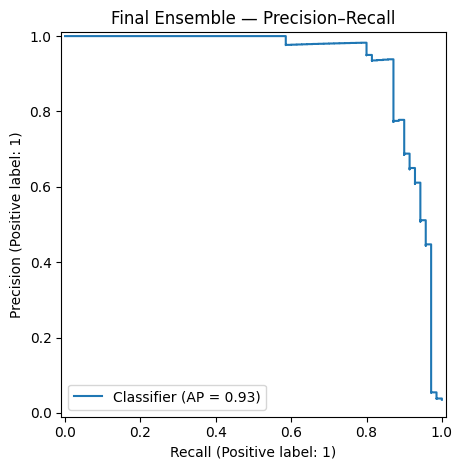

PermutationExplainer explainer: 129it [20:31,  9.62s/it]


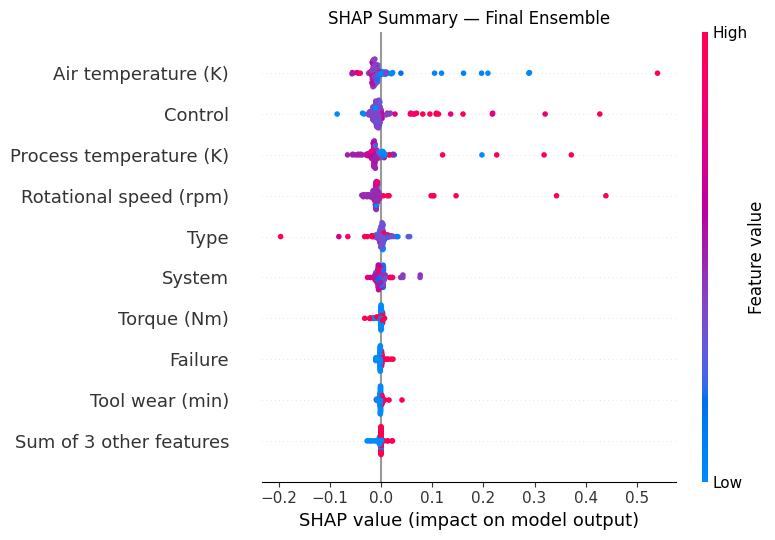

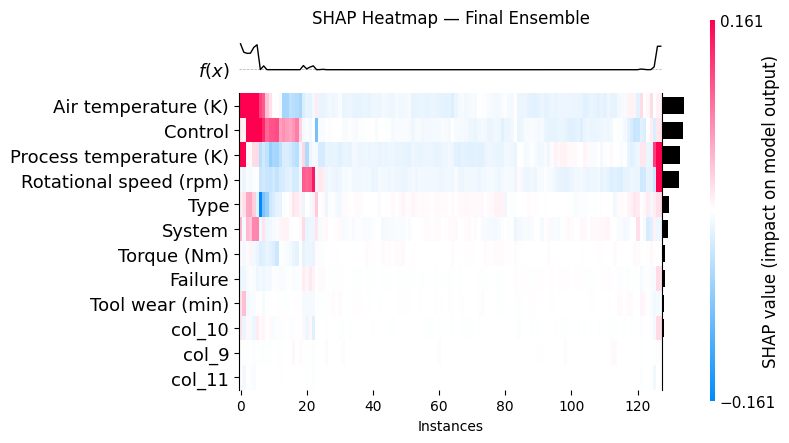

Saved: Results/ensemble_pr.pdf, Results/shap_beeswarm_ensemble.pdf, Results/shap_heatmap_ensemble.pdf


In [2]:
# ===== Final Ensemble: PR + SHAP (summary & heatmap) with REAL feature names =====
!pip -q install shap==0.46.0

import os, numpy as np, matplotlib.pyplot as plt, warnings
from sklearn.metrics import PrecisionRecallDisplay
import shap
warnings.filterwarnings("ignore")

# --- Expected vars from your notebook ---
assert "X_train_seq" in globals() and "X_test_seq" in globals() and "y_test" in globals(), \
    "Expected X_train_seq, X_test_seq, y_test to exist."

X_train = X_train_seq      # shape (N, T, F)
X_test  = X_test_seq
y_true  = y_test

# --- Try to reuse your ensemble object; else safely combine working base models ---
MODEL_CANDIDATES = ["final_ensemble_model", "meta_clf", "ensemble_model"]
existing_model = None
for name in MODEL_CANDIDATES:
    if name in globals():
        existing_model = globals()[name]
        break

def _prob1(p):
    p = np.asarray(p)
    if p.ndim == 1:      return p
    if p.shape[1] == 1:  return p.ravel()
    return p[:, 1]

def _predict_model_prob1(model, X):
    pp = getattr(model, "predict_proba", None)
    if callable(pp):
        return _prob1(pp(X))
    try:
        preds = model.predict(X, verbose=0)
    except TypeError:
        preds = model.predict(X)
    return _prob1(preds)

def make_predict_fn():
    if existing_model is not None:
        return lambda X: _predict_model_prob1(existing_model, X), "existing_model"

    # Fall back to soft-vote of only the models that work on this shape
    candidates = []
    if "cnn_bigrugru_model" in globals(): candidates.append(globals()["cnn_bigrugru_model"])
    if "lstm_model"         in globals(): candidates.append(globals()["lstm_model"])
    if "mlp_model"          in globals(): candidates.append(globals()["mlp_model"])
    # validate once
    X_probe = X_test[: min(len(X_test), 8)]
    working = []
    for m in candidates:
        try:
            _ = _predict_model_prob1(m, X_probe)
            working.append(m)
        except Exception:
            pass
    assert len(working) >= 1, "No ensemble object found and no compatible base models available."

    if len(working) == 1:
        return (lambda X: _predict_model_prob1(working[0], X)), "single_model"
    else:
        def soft_vote(X):
            probs = [_predict_model_prob1(m, X) for m in working]
            return np.mean(np.stack(probs, axis=0), axis=0)
        return soft_vote, "soft_vote"

predict_fn, _ = make_predict_fn()

# --- Precision–Recall using your precomputed ensemble_proba if present ---
if "ensemble_proba" in globals() and ensemble_proba is not None and len(ensemble_proba) == len(y_true):
    y_prob = np.asarray(ensemble_proba).ravel()
else:
    y_prob = predict_fn(X_test)

os.makedirs("Results", exist_ok=True)
PrecisionRecallDisplay.from_predictions(y_true, y_prob)
plt.title("Final Ensemble — Precision–Recall")
plt.tight_layout()
plt.savefig("Results/ensemble_pr.pdf", bbox_inches="tight")
plt.show()

# --- Build REAL feature names ---
T = X_train.shape[1]
F = X_train.shape[2] if X_train.ndim == 3 else X_train.shape[1]

def _list_from(varname):
    obj = globals().get(varname, None)
    if obj is None: return None
    try:
        # pandas Index or list-like
        return list(obj) if not hasattr(obj, "tolist") else list(obj.tolist())
    except Exception:
        return None

feature_names_base = None

# 1) feature_names
if feature_names_base is None and "feature_names" in globals():
    try:
        feature_names_base = list(globals()["feature_names"])
    except Exception:
        pass

# 2) df.columns
if feature_names_base is None and "df" in globals():
    try:
        import pandas as pd  # likely already installed
        feature_names_base = list(globals()["df"].columns)
    except Exception:
        pass

# 3) columns (common var)
if feature_names_base is None:
    feature_names_base = _list_from("columns")

# 4) num_cols + cat_cols
if feature_names_base is None:
    num_cols = _list_from("num_cols")
    cat_cols = _list_from("cat_cols")
    if num_cols or cat_cols:
        feature_names_base = (num_cols or []) + (cat_cols or [])

# Validate/trim/pad to expected per-timestep size
if X_train.ndim == 3:
    if F == 1:
        # We expect T names (each original feature became a timestep)
        if feature_names_base is not None:
            if len(feature_names_base) >= T:
                feature_names_flat = feature_names_base[:T]
            else:
                # pad with indices if too short (but keep originals first)
                feature_names_flat = feature_names_base + [f"col_{i}" for i in range(len(feature_names_base), T)]
        else:
            feature_names_flat = [f"col_{i}" for i in range(T)]
    else:
        # We expect names for F base features, then expand across time
        if feature_names_base is not None and len(feature_names_base) >= F:
            base = feature_names_base[:F]
        else:
            base = [f"col_{j}" for j in range(F)]
        feature_names_flat = [f"{base[j]}@t{t}" for t in range(T) for j in range(F)]
else:
    # 2D tabular
    P = X_train.shape[1]
    if feature_names_base is not None and len(feature_names_base) >= P:
        feature_names_flat = feature_names_base[:P]
    else:
        feature_names_flat = [f"col_{i}" for i in range(P)]

# --- SHAP with named features (3D-safe masker with flattening) ---
rng = np.random.default_rng(42)
bg_idx = rng.choice(len(X_train), size=min(100, len(X_train)), replace=False)
X_bg   = X_train[bg_idx]
X_eval = X_test[: min(128, len(X_test))]

if X_train.ndim == 3:
    feat_dim = T * F
    background_flat = X_bg.reshape(len(X_bg), feat_dim)
    X_eval_flat     = X_eval.reshape(len(X_eval), feat_dim)

    def predict_from_flat(Xflat):
        X = np.asarray(Xflat).reshape(-1, T, F)
        return predict_fn(X)

    masker = shap.maskers.Independent(background_flat)
    explainer = shap.Explainer(predict_from_flat, masker)
    exp = explainer(X_eval_flat)
else:
    masker = shap.maskers.Independent(X_bg)
    explainer = shap.Explainer(predict_fn, masker)
    exp = explainer(X_eval)

# Attach feature names for plotting
try:
    exp.feature_names = feature_names_flat
except Exception:
    pass

# SHAP summary (beeswarm) with names
try:
    shap.plots.beeswarm(exp, show=False)
except Exception:
    # fallback: legacy API if needed
    shap.summary_plot(exp.values, features=exp.data, feature_names=feature_names_flat, show=False)
plt.title("SHAP Summary — Final Ensemble")
plt.tight_layout()
plt.savefig("Results/shap_beeswarm_ensemble.pdf", bbox_inches="tight")
plt.show()

# SHAP heatmap with names
try:
    shap.plots.heatmap(exp, max_display=min(50, len(feature_names_flat)), show=False)
    plt.title("SHAP Heatmap — Final Ensemble")
    plt.tight_layout()
    plt.savefig("Results/shap_heatmap_ensemble.pdf", bbox_inches="tight")
    plt.show()
except Exception:
    # Fallback: manual heatmap with ordered top features
    vals = np.asarray(exp.values)
    vals2d = vals if vals.ndim == 2 else vals.reshape(vals.shape[0], -1)
    order = np.argsort(np.abs(vals2d).mean(axis=0))[::-1][: min(50, vals2d.shape[1])]
    plt.imshow(vals2d[:, order].T, aspect="auto")
    plt.yticks(range(len(order)), [feature_names_flat[i] for i in order])
    plt.xlabel("Samples"); plt.ylabel("Top features")
    plt.title("SHAP Heatmap — Final Ensemble (fallback)")
    plt.tight_layout()
    plt.savefig("Results/shap_heatmap_ensemble.pdf", bbox_inches="tight")
    plt.show()

print("Saved:",
      "Results/ensemble_pr.pdf, Results/shap_beeswarm_ensemble.pdf, Results/shap_heatmap_ensemble.pdf")
